# Model 4: Review Baseline Example
Here, we will use all of the encoded data and sentiment scores to create a new model using numerical features.

In [1]:
# ===============LICENSE_START=======================================================
# Apache-2.0
# ===================================================================================
# Copyright (C) 2019 AT&T Intellectual Property  All rights reserved.
# ===================================================================================
# This software file is distributed by AT&T
# under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ===============LICENSE_END=========================================================

import pandas as pd  # data read
from sklearn import preprocessing  # data ETL
import os,sys  # file checks
import dill as pickle   # serialize functions and data as compressed binary 
import gzip  # compression 
import yaml   # configuration file
from sklearn import ensemble # classifier
from sklearn import metrics # metric plotting
from sklearn import model_selection
from matplotlib import pyplot as plt
import time

import util_review

# for interactive graphs
# %matplotlib notebook  

config_path = 'config.yaml'
if not os.path.isfile(config_path):
    print("Sorry, can't find the configuration file {}, aborting.".format(config_path))
    sys.exit(-1)
config = yaml.safe_load(open(config_path))

In [2]:
# read our larger datasets as binary files
with gzip.open(config["path"]["etl"], 'rb') as f:
    df = pickle.load(f)
# read our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_preproc"], 'rb') as f:
    etl = pickle.load(f)   # note that we use local variable 'etl' instead of 'models'
# read our features from the sentiment model
with gzip.open(config["path"]["sentiment"], 'rb') as f:
    df_sentiment = pickle.load(f)   # note that we use local variable 'df_sentiment'
    
print(df.keys())
print("Loaded Dimensionality: Training({}), RawTest({})".format(
    df["X_train"].shape, df["X_test"].shape ))

print(df_sentiment.keys())
print("Loaded Sentiment Dimensionality: Training({}), RawTest({})".format(
    df_sentiment["X_train_raw"].shape, df_sentiment["X_test"].shape ))

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'X_train_raw'])
Loaded Dimensionality: Training((20299, 1115)), RawTest((5075, 6))
dict_keys(['X_test', 'X_train_raw', 'col_sentiment'])
Loaded Sentiment Dimensionality: Training((20299, 2)), RawTest((5075, 2))


# Preprocessing 
Preprocessing will run through required steps to generate extra columns and normalize (according to inputs) for the underlying predictors to train/evaluate a sample.

**NOTE** In this notebook (versus training our raw model), we will also augment the training and testing data to include sentiment features from our selected sentiment classifiers.

In [9]:
# save the FUNCTION and a data example for later use!
df["X_test_enc"] = df["X_test"].copy()
df["X_test_enc"] = etl["fn_preproc"](etl, df["X_test"])
df["X_train_enc"] = df["X_train"].copy()

In [10]:
models = {}
models["col_norm"] = []

# TODO: ADD LOAD AND FUSION OF SENTIMENT SCORES FOR COLUMNS
for col in df_sentiment["X_test"].columns:
    feat_n = len(df_sentiment["X_test"][col].sample(1))
    col_name = ["{}_{:03d}".format(col, idx) for idx in range(feat_n)]
    models["col_norm"] += col_name
    df_encode = pd.DataFrame(df_sentiment["X_test"][col].values.tolist(), 
                              columns=col_name, index=df_sentiment["X_test"].index)
    df["X_test_enc"] = df["X_test_enc"].join(df_encode)

    df_encode = pd.DataFrame(df_sentiment["X_train_raw"][col].values.tolist(), 
                              columns=col_name, index=df_sentiment["X_train_raw"].index)
    df["X_train_enc"] = df["X_train_enc"].join(df_encode)


## Stats on New Features
We've now incorporated all of the new sentiment features.  Let's check the distribution and range of these new features before we throw them into our learning again.


New Columns: ['yelp_000', 'twitter_000']


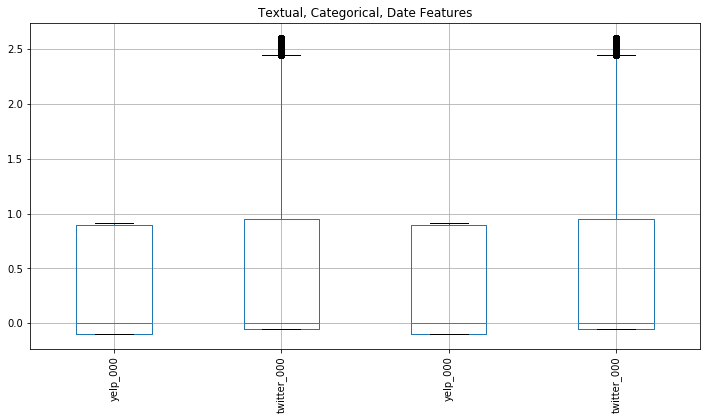

In [11]:

# fit the scaler on training
print("New Columns: {}".format(models["col_norm"]))
models, df["X_train_enc"][models["col_norm"]] = util_review.preproc_scaler(
    models, df["X_train_enc"][models["col_norm"]], df["X_train_enc"][models["col_norm"]].copy(), True)
_, df["X_test_enc"][models["col_norm"]] = util_review.preproc_scaler(
    models, df["X_test_enc"][models["col_norm"]])


# Performance Evaluation
This quick function will plot the performance of our algorithm by finding the [area under the curve (aka ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

For basic models, a number of sample models from scikit are included as possibilities, like a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and or a [GradientBoostedClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier).  The model utilized is chosen by the configuration file setting `model_type`.

A more advanced model training process is also included called [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).  Here, we use cross validalidation to explore a number of parameter settings (and random starts) to find the best performing model configutation.  This option is also controlled in the configuration file by the parameter `cross_validate` but by default it is disabled because of the expected run time.

Finally, we can use [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) (here [average_precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) as determined by the config setting `scoring`) to more easily compare the performance of different models that we build.  It should be noted that no tunings for either model was done, so it doesn't speak to the overall fitness of one type versus another.

In [14]:
# here, we test two simple classifiers and plot their performance
time_start = time.time()
models = {}

# first, choose our model according to specification
if config["training"]["model_type"].lower()=="rf":
    # use random forest as our classifier
    models["best"] = ensemble.RandomForestClassifier(n_estimators=100)
    # create some estimator parameter set
    models["param"] = {"n_estimators":(50, 100, 200), "max_depth":(2,5)}
elif config["training"]["model_type"].lower()=="gbm":
    # use gradient boosting as our classifier
    models["best"] = ensemble.GradientBoostingClassifier()
    # create some estimator parameter set
    models["param"] = {"n_estimators":(50, 100, 200), "max_features": (2,), "learning_rate":(0.1, 0.2)}
elif config["training"]["model_type"].lower()=="bayes":
    from sklearn import naive_bayes
    # use naive bayes as our classifier
    models["best"] = naive_bayes.MultinomialNB()
    # create some estimator parameter set
    models["param"] = {"alpha":(1.0, 0.7)}
# elif X:
#     from sklearn import naive_bayes
#     # use naive bayes as our classifier
#     models["best"] = naive_bayes.MultinomialNB()
#     # create some estimator parameter set
#     models["param"] = {"alpha":(1.0, 0.7)}
#     sklearn.neighbors.KNeighborsClassifier
else:
    raise Exception("Sorry, {} is an unknown model type at this time, why not create it!?".format(config["training"]["model_type"]))

    
# want to cross-validate for training well?
#   warning: this can take quite a while because of the sample count...
if config["training"]["cross_validate"]:
    models["cv"] = model_selection.GridSearchCV(models["best"], models["param"], cv=3, verbose=2, 
                          n_jobs=config["training"]["threads"], scoring=config["training"]["scoring"], 
                          refit=config["training"]["scoring"][0], return_train_score=True)
    # execute grid search
    print("Executing grid search ({})".format(clf))
    scores = models["cv"].fit(df["X_train_enc"], df["y_train"].values.ravel())
    models["best"] = models["cv"].best_estimator_
    print(models["cv"].cv_results_)
    # print out best performance
    print(models["best"])
    for t in ["train", "test"]:
        k = "mean_{}_{}".format(t, config["training"]["scoring"][0])
        print("{}: {}".format(k, models["cv"].cv_results_[k]))
# just do normal training...
else: 
    models["best"].fit(df["X_train_enc"], df["y_train"].values.ravel())
models["time_train"] = (time.time() - time_start)
    

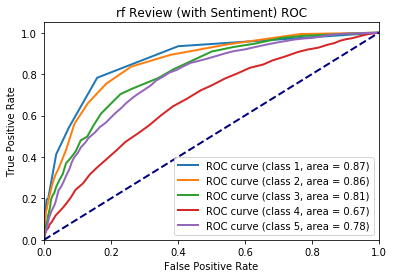

rf+Sentiment AUC: 0.888, trained time: 20.737s


In [23]:

# print performance!
auc_class = util_review.draw_roc(df["X_test_enc"], df["y_test"], 
                                 classifier=models["best"], 
                                 title="{} Review (with Sentiment) ROC".format(config["training"]["model_type"]))
print("{}+Sentiment AUC: {:0.3f}, trained time: {:0.3f}s".format(config["training"]["model_type"], auc_class, models["time_train"]))


In [24]:
# finally, write out our intermediate data...
# and write out our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_fused"], 'wb') as f:
    pickle.dump(models, f)


# What Happened?
If we compare the original performance (specifically the ROC plots) to the one plotted above, we can see that the sentiment features -- even the small handfull of them -- has improved the shape of our function and overall performance.  Specifically, the ROC curve has been pulled up and to the left, at the intersection of lower false positives and higher true positives.  All classes except `class 4` (our worst individual performer) seem to show this effect.  The mean AUC itself has also improved but only marginally.

## Additional Shared Insights
Taking these findings as an example, this should motivate the reuse of other experts' models.  Remember, all that we did in this case was utilize someone else's hard work in sentiment clasification and join that to our prior data via early fusion.  